In [1]:
metrics = {
    "profitability": {
        "class_weight": 0.30,
        "weights": [1.0], 
        "metrics": {
            "oper_margin": {
                "lower_is_better": False,
                "thresholds": [
                    (0.4, float("inf")),
                    (0.35, 0.4),
                    (0.3, 0.35),
                    (0.25, 0.3),
                    (0.2, 0.25),
                    (0.15, 0.2),
                    (0.1, 0.15),
                    (0.05, 0.1),
                    (float("-inf"), 0.05),
                ],
            }
        },
    },
    "leverage_coverage": {
        "class_weight": 0.55,
        "weights": [0.4, 0.3, 0.3],
        "metrics": {
            "debt_to_equity": {
                "lower_is_better": True,
                "thresholds": [
                    (0, 0.4),
                    (0.4, 0.8),
                    (0.8, 1.2),
                    (1.2, 1.6),
                    (1.6, 2),
                    (2, 2.5),
                    (2.5, 3),
                    (3, 4),
                    (4, float("inf")),
                ],
            },
            "tot_debt_to_ebitda": {
                "lower_is_better": True,
                "thresholds": [
                    (0, float("-inf")),
                    (0.4, 0.8),
                    (0.8, 1.2),
                    (1.2, 1.6),
                    (1.6, 2),
                    (2, 2.5),
                    (2.5, 3),
                    (3, 4),
                    (4, float("inf")),
                ],
            },
            "ebitda_to_tot_int_exp": {
                "lower_is_better": False,
                "thresholds": [
                    (25, float("inf")),
                    (20, 25),
                    (15, 20),
                    (10, 15),
                    (5, 10),
                    (3, 5),
                    (1, 3),
                    (0, 1),
                    (float("-inf"), 0),
                ],
            },
        },
    },
    "efficiency": {
        "class_weight": 0.15,
        "weights": [0.5, 0.5],
        "metrics": {
            "return_on_asset": {
                "lower_is_better": False,
                "thresholds": [
                    (0.15, float("inf")),
                    (0.10, 0.15),
                    (0.08, 0.10),
                    (0.06, 0.08),
                    (0.04, 0.06),
                    (0.02, 0.04),
                    (0.00, 0.02),
                    (-0.02, 0.00),
                    (float("-inf"), -0.02)
                ],
            },
            "asset_turnover": {
                "lower_is_better": False,
                "thresholds": [
                    (4.0, float("inf")),
                    (3.0, 4.0),
                    (2.0, 3.0),
                    (1.5, 2.0),
                    (1.0, 1.5),
                    (0.75, 1.0),
                    (0.5, 0.75),
                    (0.25, 0.5),
                    (float("-inf"), 0.25)
                ],
            },
        },
    },
}

In [2]:
class CreditRatingCalculator:
    def __init__(self, metrics):
        self.metrics = metrics
        
    def _calculate_metric_score(self, metric, thresholds, inverse):
        for score, (lower, upper) in enumerate(thresholds, start=1):
            if (inverse and metric <= upper) or (not inverse and metric >= lower):
                return score
        return len(thresholds) // 2 # else return the middle score

    def _calculate_category_score(self, category_metrics, ratios):
        total_weighted_score = 0

        for metric, weight in zip(
            category_metrics["metrics"].items(), category_metrics["weights"]
        ):
            metric_name, metric_data = metric
            value = ratios[metric_name]
            score = self._calculate_metric_score(
                value, metric_data["thresholds"], metric_data["lower_is_better"]
            )
            total_weighted_score += score * weight

        return total_weighted_score

    def _calculate_scores(self, ratios):
        scores = {}
        for category, category_data in self.metrics.items():
            category_score = self._calculate_category_score(category_data, ratios)
            scores[category] = category_score
        return scores

    def _calculate_weighted_score(self, scores):
        weights = {
            category: category_data["class_weight"]
            for category, category_data in self.metrics.items()
        }
        return sum(scores[category] * weight for category, weight in weights.items())

    def _determine_credit_rating(self, weighted_score):
        credit_ratings = [
            (1.5, "Aaa"),
            (2.5, "Aa"),
            (3.5, "A"),
            (4.5, "Baa"),
            (5.5, "Ba"),
            (6.5, "B"),
            (7.5, "Caa"),
            (8.5, "Ca"),
            (float("inf"), "C"),
        ]

        for threshold, rating in credit_ratings:
            if weighted_score < threshold:
                return rating

    def calculate_credit_rating(self, ratios):
        self.scores = self._calculate_scores(ratios)
        self.credit_score = self._calculate_weighted_score(self.scores)
        self.credit_rating = self._determine_credit_rating(self.credit_score)

In [4]:
ratios = {
    'oper_margin': 6.0,
    'debt_to_equity': 0.2,
    'tot_debt_to_ebitda': 0.5,
    'ebitda_to_tot_int_exp': 0.6,
    'return_on_asset': .02,
    'asset_turnover': 0.2,
}

model = CreditRatingCalculator(metrics)
model.calculate_credit_rating(ratios)
print(f"Class Scoring: {model.scores}")
print(f"Credit Score: {model.credit_score}")
print(f"Credit Rating: {model.credit_rating}")

Class Scoring: {'profitability': 1.0, 'leverage_coverage': 3.4, 'efficiency': 7.5}
Credit Score: 3.295
Credit Rating: A


In [4]:
import pandas as pd 

In [8]:
df = pd.read_parquet("research/JALSH Index_dataset_2000_2024_clean.parquet")

In [14]:
import matplotlib.pyplot as plt

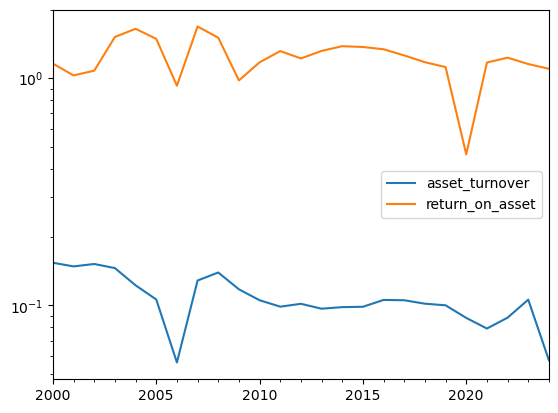

In [18]:
df['ABG SJ Equity'][['asset_turnover', 'return_on_asset']].plot()
plt.yscale("log");

In [19]:
from quantstats import extend_pandas
extend_pandas()

In [42]:
efficiency_metrics = ['asset_turnover', 'return_on_asset'] 
m = pd.concat({comp: df[comp][efficiency_metrics[0]] for comp in df.columns.levels[0]}, axis=1)

In [106]:
df = pd.read_csv("research/JALSH Index_dataset_2000_2024_clean.csv", index_col=0, header=[0, 1])
classfier = pd.read_excel("research/classification_data.xlsx", index_col=0)
metrics = pd.read_excel("research/metrics_full.xlsx", index_col=0)

In [53]:
def filter_securities(filters, data=classfier):
    
    # Apply filters directly on the transposed
    filtered_data = data.query(
        ' and '.join(f'`{k}` == "{v}"' for k, v in filters.items())
    )
    
    return list(filtered_data.index)

In [55]:
classfier.sector.unique()

array(['Financial', 'Consumer, Non-cyclical', 'Industrial',
       'Basic Materials', 'Diversified', 'Consumer, Cyclical',
       'Communications', 'Technology', 'Energy'], dtype=object)

In [57]:
classfier.industry.unique()

array(['Banks', 'Commercial Services', 'Electronics',
       'Miscellaneous Manufactur', 'Diversified Finan Serv',
       'Building Materials', 'Mining', 'Investment Companies',
       'Pharmaceuticals', 'Beverages', 'Agriculture', 'REITS',
       'Holding Companies-Divers', 'Distribution/Wholesale', 'Food',
       'Telecommunications', 'Computers', 'Retail', 'Insurance',
       'Real Estate', 'Coal', 'Transportation', 'Entertainment',
       'Auto Parts&Equipment', 'Iron/Steel', 'Software',
       'Healthcare-Services', 'Private Equity',
       'Energy-Alternate Sources', 'Forest Products&Paper', 'Internet',
       'Chemicals', 'Engineering&Construction', 'Lodging'], dtype=object)

In [66]:
f = filter_securities({"industry": "Engineering&Construction"})

,RBX SJ Equity,WBO SJ Equity
oper_margin,10.234529,4.335948
return_on_asset,8.205759,5.572577
tot_debt_to_tot_asset,14.328108,2.921138
tot_debt_to_tot_cap,20.503625,8.074190
tot_debt_to_tot_eqy,26.184412,9.188145
asset_turnover,1.262381,2.148323
ebitda_margin,13.855970,5.258228
tot_debt_to_ebitda,0.892198,0.311257
interest_coverage_ratio,11.606127,212.325909
ebitda_to_tot_int_exp,16.707004,278.833027


In [107]:
metrics.loc['asset_turnover'].quantile([0, .05, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95])

0.00    0.016101
0.05    0.063452
0.10    0.078841
0.20    0.100008
0.30    0.176090
0.40    0.456206
0.50    0.617119
0.60    0.866586
0.70    1.080595
0.80    1.345202
0.90    2.029703
0.95    2.449184
Name: asset_turnover, dtype: float64

In [89]:
import numpy as np

In [90]:
np.linspace(0, 20, 9)

array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ])

In [95]:
metrics.T['return_on_asset'].min()

AttributeError: 'dict' object has no attribute 'T'

In [93]:
import numpy as np

# Generate linspace
linspace = np.linspace(0, 20, 9)

# Create thresholds
thresholds = [(linspace[i], linspace[i+1]) for i in range(len(linspace)-1)]

# Correct and reverse the thresholds
corrected_thresholds = [(-np.inf, linspace[0])] + \
                       [(linspace[i], linspace[i+1]) for i in range(len(linspace)-1)] + \
                       [(linspace[-1], np.inf)]

# Reverse the corrected thresholds
reversed_corrected_thresholds = corrected_thresholds[::-1]

reversed_corrected_thresholds


[(20.0, inf),
 (17.5, 20.0),
 (15.0, 17.5),
 (12.5, 15.0),
 (10.0, 12.5),
 (7.5, 10.0),
 (5.0, 7.5),
 (2.5, 5.0),
 (0.0, 2.5),
 (-inf, 0.0)]